In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import cifar10
from keras.utils import np_utils

In [2]:
#import zipfile
import os
#files = zipfile.ZipFile('New_Rice_Dataset.zip','r')
#files.extractall(os.getcwd())
#files.close()

print(os.getcwd())

C:\Users\ccyel\machine_learning\hw2_第二組


In [3]:
#import os
#path = './New_Rice_Dataset/train/Tai-Nong No.81'
#dirlist = os.listdir(path)
#for i in dirlist:
#    if i == 'desktop.ini':
#        continue
#    else:
#        print(i)

In [4]:
import matplotlib.pyplot as plt
from matplotlib.image import imread 

def show_rice_image(image_name):
    filename = './New_Rice_Dataset/train/' + image_name
    # load image pixels
    image = imread(filename)
    plt.figure(figsize=(8,8))
    # plot raw pixel data
    plt.imshow(image)
    # show the figure
    plt.show()

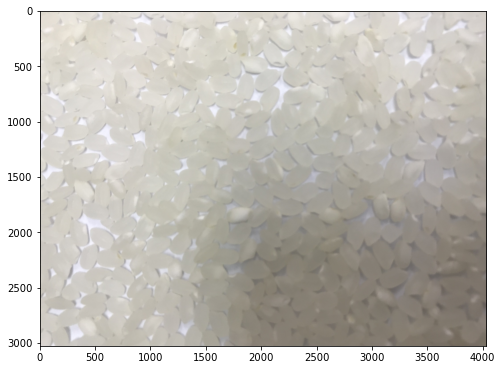

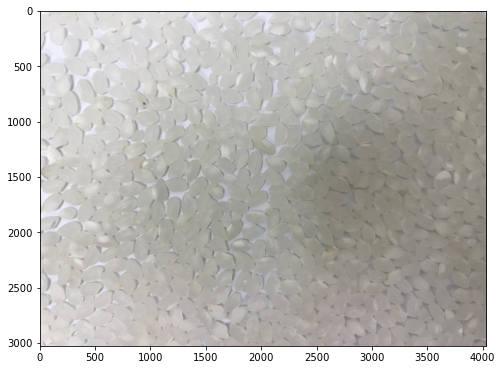

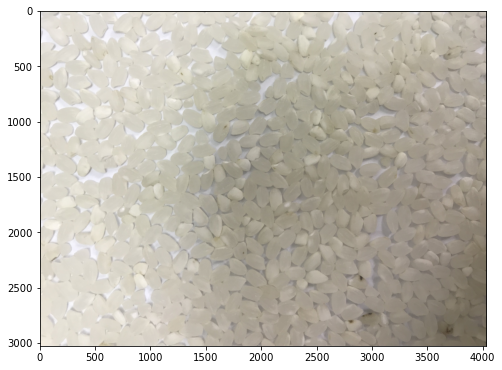

In [5]:
show_rice_image('Tai-Nong No.81/Tai-Nong No.81_55.jpg')
show_rice_image('Tai-Nong No.82/Tai-Nong No.82_35.jpg')
show_rice_image('Tai-Nong No.83/Tai-Nong No.83_45.jpg')

In [6]:
train_dir = './New_Rice_Dataset/train'
validation_dir = './New_Rice_Dataset/validation'
test_dir = './New_Rice_Dataset/test'

In [7]:
import keras
from keras.applications.vgg16 import VGG16

#weights = imagenet 即使用imagenet預先訓練好的資料
#include_top = False 即只利用VGG16萃取特徵，後面分類要自己設計
rice_conv_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(224, 224, 3))

In [8]:
rice_conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
rice_conv_base.trainable = True

set_trainable = False
for layer in rice_conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [10]:
from keras import models
from keras import layers

#可以再做一次捲積

model = models.Sequential()
model.add(layers.Flatten())
# 以 relu 函數作為 activation function
model.add(layers.Dense(2048, activation='relu'))#第一層的input要是上面VGG的output
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))#可以增減層


In [11]:
from keras import optimizers
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5), 
              # learning rate 設為 0.00001
              metrics=['acc'])

In [12]:
from keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np

# 以下設定資料擴增的方法：含隨機圖片旋轉(0到180度)、左右平移、水平與鉛直翻轉
train_datagen = ImageDataGenerator(
    rotation_range=180,
    #width_shift_range = 0.2,
    #height_shift_range = 0.2,
    horizontal_flip=True,
    vertical_flip=True)

batch_size = 20

# 以下定義如何將訓練集的影像轉換為張量
def train_extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7,7,512))
    labels = np.zeros(shape=(sample_count))
    generator = train_datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = rice_conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

datagen = ImageDataGenerator()

# 以下定義如何將驗證集、測試集的影像轉換為張量
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7,7,512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = rice_conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [13]:
train_features, train_labels = train_extract_features(train_dir, 1200)
validation_features, validation_labels = extract_features(validation_dir, 150)
test_features, test_labels = extract_features(test_dir, 150)

train_features = np.reshape(train_features, (1200, 7,7,512))
validation_features = np.reshape(validation_features, (150, 7,7,512))
test_features = np.reshape(test_features, (150, 7,7,512))

Found 1200 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [14]:
new_validation_labels = validation_labels
new_train_labels = train_labels
new_test_labels = test_labels

In [15]:
from tensorflow.keras.utils import to_categorical

new_validation_labels = to_categorical(new_validation_labels)
new_train_labels = to_categorical(new_train_labels)
new_test_labels = to_categorical(new_test_labels)

In [16]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_acc', patience=10, mode='max', verbose=1)

history = model.fit(
    train_features, new_train_labels,
    epochs=50,
    batch_size=32,
    callbacks=[es],
    validation_data=(validation_features, new_validation_labels))

Epoch 1/50
38/38 [==============================] - 61s 1s/step - loss: 2.9316 - acc: 0.4258 - val_loss: 1.0583 - val_acc: 0.4867
Epoch 2/50
38/38 [==============================] - 50s 1s/step - loss: 2.0309 - acc: 0.5442 - val_loss: 0.9240 - val_acc: 0.5800
Epoch 3/50
38/38 [==============================] - 50s 1s/step - loss: 1.5001 - acc: 0.6450 - val_loss: 1.0678 - val_acc: 0.5600
Epoch 4/50
38/38 [==============================] - 49s 1s/step - loss: 1.1342 - acc: 0.7175 - val_loss: 0.9367 - val_acc: 0.6400
Epoch 5/50
38/38 [==============================] - 49s 1s/step - loss: 0.9106 - acc: 0.7617 - val_loss: 0.8172 - val_acc: 0.6400
Epoch 6/50
38/38 [==============================] - 49s 1s/step - loss: 0.6908 - acc: 0.8225 - val_loss: 0.7987 - val_acc: 0.6600
Epoch 7/50
38/38 [==============================] - 49s 1s/step - loss: 0.5989 - acc: 0.8442 - val_loss: 0.8460 - val_acc: 0.6600
Epoch 8/50
38/38 [==============================] - 49s 1s/step - loss: 0.4865 - acc: 0.86

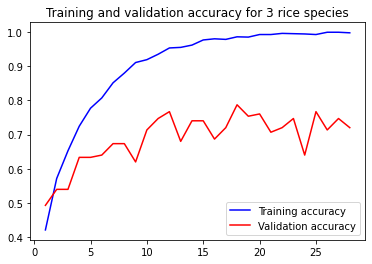

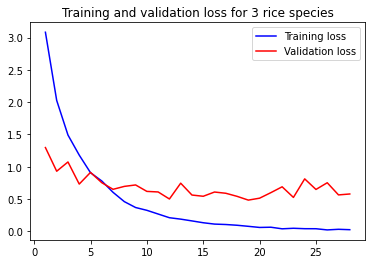

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy for 3 rice species')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss for 3 rice species')
plt.legend()

plt.show()

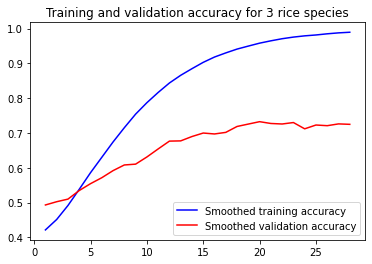

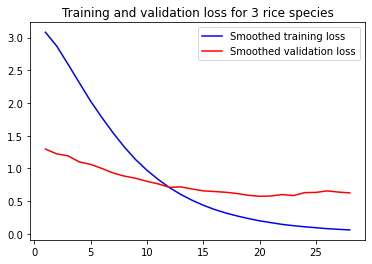

In [18]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'b', label='Smoothed training accuracy')
plt.plot(epochs,
         smooth_curve(val_acc), 'r', label='Smoothed validation accuracy')
plt.title('Training and validation accuracy for 3 rice species')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'b', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'r', label='Smoothed validation loss')
plt.title('Training and validation loss for 3 rice species')
plt.legend()

plt.show()

In [19]:
score, acc = model.evaluate(test_features, new_test_labels, 
                            batch_size=20, verbose = 1)
print('測試的準確率:', acc*100)

8/8 [==============================] - 1s 59ms/step - loss: 0.2690 - acc: 0.9067
測試的準確率: 90.66666960716248


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2048)              51382272  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 51,388,419
Trainable params: 51,388,419
Non-trainable params: 0
_________________________________________________________________


In [19]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

new_test_labels_arg = np.argmax(new_test_labels,axis=1)
prediction = model.predict(test_features)
prediction_arg = np.argmax(prediction,axis=1)

print(precision_score(new_test_labels_arg,prediction_arg,average='micro'))
print(recall_score(new_test_labels_arg,prediction_arg,average='micro'))
print(f1_score(new_test_labels_arg,prediction_arg,average='micro'))

0.9066666666666666
0.9066666666666666
0.9066666666666666


In [32]:
def plot_text_labels_prediction(text,labels,prediction,idx,num=10):
    total = 0
    if num>25: num=25 
    for i in range(0, num):
        print("label=" +str(labels[idx])+
              ",predict="+str(prediction[idx])) 
        print("==============================")
        if np.argmax(labels[idx]) == prediction[idx]:
            total = total + 1
        
        idx+=1
        if idx >= len(text):
            break
    print('預測準確機率為',(total/num)*100)
#    plt.show()

In [33]:
plot_text_labels_prediction(test_features,new_test_labels,prediction_arg,idx=0,num=10)

label=[1. 0. 0.],predict=0
label=[0. 0. 1.],predict=0
label=[0. 1. 0.],predict=1
label=[0. 1. 0.],predict=1
label=[0. 0. 1.],predict=1
label=[1. 0. 0.],predict=0
label=[1. 0. 0.],predict=0
label=[0. 0. 1.],predict=2
label=[0. 0. 1.],predict=2
label=[0. 1. 0.],predict=1
預測準確機率為 80.0


In [20]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
x_train = X_train.astype('float32')/255
x_test = X_test.astype('float32')/255
y_train = np_utils.to_categorical(Y_train)
y_test = np_utils.to_categorical(Y_test)

In [21]:
y_train.shape

(50000, 10)

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [23]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=3, input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=64, kernel_size=3, input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=2))
#model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(10, activation='softmax'))

In [24]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                  

In [25]:
from keras.callbacks import EarlyStopping

#metrics_list = ['accuracy',precision_score,recall_score,f1_score]

es = EarlyStopping(monitor='val_acc', patience=1, mode='max', verbose=1)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='acc')
train_history = model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=128, callbacks = [es], verbose=1)

Epoch 1/10
313/313 [==============================] - 963s 3s/step - loss: 1.6222 - acc: 0.4017 - val_loss: 1.2142 - val_acc: 0.5605
Epoch 2/10
313/313 [==============================] - 943s 3s/step - loss: 1.1080 - acc: 0.6026 - val_loss: 0.9821 - val_acc: 0.6540
Epoch 3/10
313/313 [==============================] - 978s 3s/step - loss: 0.8669 - acc: 0.6959 - val_loss: 0.8501 - val_acc: 0.7030
Epoch 4/10
313/313 [==============================] - 960s 3s/step - loss: 0.7208 - acc: 0.7478 - val_loss: 0.7626 - val_acc: 0.7328
Epoch 5/10
313/313 [==============================] - 927s 3s/step - loss: 0.5957 - acc: 0.7914 - val_loss: 0.7196 - val_acc: 0.7529
Epoch 6/10
313/313 [==============================] - 904s 3s/step - loss: 0.4835 - acc: 0.8296 - val_loss: 0.7133 - val_acc: 0.7603
Epoch 7/10
313/313 [==============================] - 896s 3s/step - loss: 0.4050 - acc: 0.8558 - val_loss: 0.7120 - val_acc: 0.7749
Epoch 8/10
313/313 [==============================] - 891s 3s/step - 

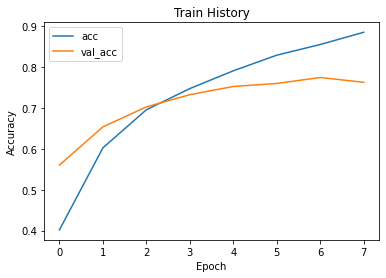

In [26]:
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('Train History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

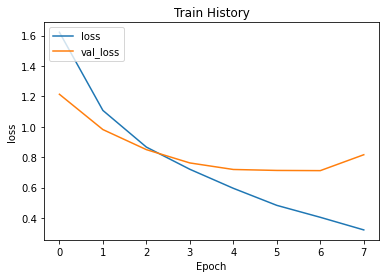

In [27]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Train History')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [28]:
loss, accuracy = model.evaluate(x_test, y_test)

313/313 [==============================] - 64s 204ms/step - loss: 0.8369 - acc: 0.7637


In [29]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

y_test_arg = np.argmax(y_test,axis=1)
prediction = model.predict(x_test)
prediction_arg = np.argmax(prediction,axis=1)

print(precision_score(y_test_arg,prediction_arg,average='micro'))
print(recall_score(y_test_arg,prediction_arg,average='micro'))
print(f1_score(y_test_arg,prediction_arg,average='micro'))

0.7637
0.7637
0.7637


In [30]:
def plot_text_labels_prediction(text,labels,prediction,idx,num=10):
    if num>25: num=25 
    for i in range(0, num):
        print("label=" +str(labels[idx])+
              ",predict="+str(prediction[idx])) 
        print("==============================")
        
        idx+=1
        if idx >= len(text):
            break
    plt.show()

In [31]:
plot_text_labels_prediction(x_test,y_test,prediction_arg,idx=0,num=10)

label=[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.],predict=3
label=[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.],predict=8
label=[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.],predict=8
label=[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.],predict=8
label=[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.],predict=6
label=[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.],predict=6
label=[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.],predict=1
label=[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.],predict=6
label=[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.],predict=3
label=[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.],predict=1


In [32]:
label_dict={0:'airplay',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

In [36]:
def show_Predicted_Probability(y,prediction,x_img,Predicted_Probability,i):
    print('label:',label_dict[y[i]],'prediction:',label_dict[prediction[i]])
    plt.figure(figsize=(2,2))
    plt.imshow(np.reshape(x_img[i],(32,32,3)))
    plt.show()
    for j in range(10):
        print(label_dict[j]+' probability:%1.9f'%Predicted_Probability[i][j])

label: horse prediction: horse


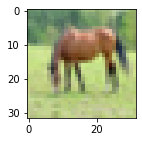

airplay probability:0.000000000
automobile probability:0.000000000
bird probability:0.000000000
cat probability:0.000000000
deer probability:0.000072936
dog probability:0.000000005
frog probability:0.000000000
horse probability:0.999927044
ship probability:0.000000000
truck probability:0.000000000


In [42]:
show_Predicted_Probability(y_test_arg,prediction_arg,x_test,prediction,60)

In [38]:
def show_Predicted(y,prediction,x_img,Predicted_Probability,i):
    for j in range(10):
        print('label:',label_dict[y[i]],'prediction:',label_dict[prediction[i]])
        plt.figure(figsize=(2,2))
        plt.imshow(np.reshape(x_img[i],(32,32,3)))
        plt.show()
        i = i + 1

label: ship prediction: ship


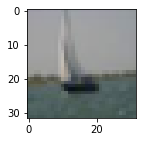

label: horse prediction: horse


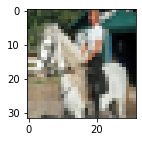

label: horse prediction: cat


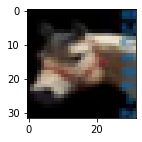

label: deer prediction: horse


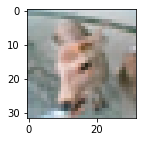

label: frog prediction: dog


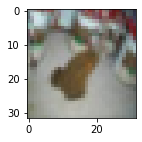

label: horse prediction: horse


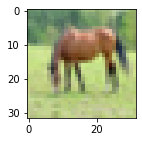

label: cat prediction: dog


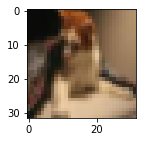

label: frog prediction: frog


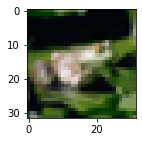

label: cat prediction: airplay


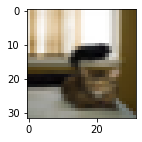

label: frog prediction: frog


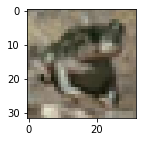

In [39]:
show_Predicted(y_test_arg,prediction_arg,x_test,prediction,55)